# Heart Disease Classification

# TODO
- transform categories 'thal' -> 3,6,7 to 0,1,2
- outlier cholesterine -> remove
- confusion matrix
- patient information
- network
- explain hyperparameter tuning, gridsearch, pipe
- test different scalers
- add random forest
- linear classifier
- decision tree
- scaler: standard, minmax, robust (bei outliern gut)
- scaler pipe alle??


- disadvantages of a small dataset
- critical anlysis (e.g. old data, small dataset)

## Attribute Description

- age: in years
- sex: (1 = male; 0 = female)
- cp: chest pain type
    - Value 1: typical angina 
    - Value 2: atypical angina 
    - Value 3: non-anginal pain 
    - Value 4: asymptomatic 
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restec: gresting electrocardiographic results
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
- ca: number of major vessels (0-3) colored by flourosopy
- thal: thallium heart scan, 3 = normal; 6 = fixed defect; 7 = reversable defect
- target: 1 or 0

Original source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Goal: Prediciting the presence of a heart disease based on the patient's given data 

In [29]:
import numpy as np 
import pandas as pd
import os
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42

print(os.listdir("./data"))

['heart.csv']


In [30]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data Exploration

In [31]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


### Data Visualization

#### General Patient Information

In [33]:
df['cp'].value_counts()

0    143
2     87
1     50
3     23
Name: cp, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000294256542B0>,
      dtype=object)

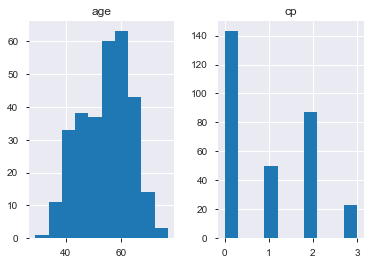

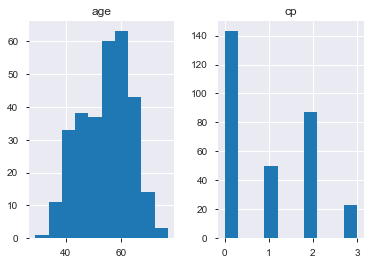

In [34]:
#df[['age']].hist()
df[['age', 'cp']].hist()
df[['age', 'cp']].hist()

In [35]:
#ct2_age = pd.crosstab(df.target, df.age)
#ct2_age.plot.bar(stacked=True)

#x = df['age'].value_counts()

#y_0 = df[df['target'] == 0]
#y_0 = y['age'].value_counts()

#y_1 = df[df['target'] == 1]
#y_1 = y['age'].value_counts()

#y_1 + y_0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000294247EED68>]],
      dtype=object)

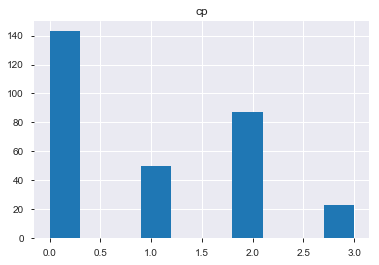

In [36]:
df[['cp']].hist()

#### Medical Background

- trestbps: resting blood pressure (in mm Hg on admission to the hospital) (Ruhepuls gemessen an Millimeter Quecksilbersäule, Durchschnittswert bei Erwachsenen: 120-129)
- chol: serum cholestoral in mg/dl (Cholesterin in mg pro Deziliter, Durchschnitt ist 240 mg/dl)
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true (deutlich zu hoch); 0 = false) (Nüchternblutzucker, Durchschnitt: 65-100 ml/dl)
- restec: resting electrocardiographic results (EKG Ergebnisse --> 0 normal, 1 & 2 Abnormalitäten)
- thalach: maximum heart rate achieved (Maximale Herzfrequenz (bei größtmöglicher Anstrengung) Herzschläge/ Minute)
- exang: exercise induced angina (1 = yes; 0 = no) ("Engegefühl" bei sportlicher Aktivität)
- oldpeak: ST depression induced by exercise relative to rest (Befund bei EKG (ST Streckensenkung), der eine bestimmte Basislinie nicht unterschreiten sollte)
- slope: the slope of the peak exercise ST segment (EKG Ergebnisse, "peaks" des ST segments)
    -- Value 1: upsloping 
    -- Value 2: flat 
    -- Value 3: downsloping 
- ca: number of major vessels (0-3) colored by fluoroscopy (Betrachtung von Hauptgefäßen bei Durchführung einer Durchleuchtung. Verstopfte Gefäße werden beim Durchleuchten nicht erkannt -> Je mehr, desto besser)
- thal: thallium heart scan, 3 = normal; 6 = fixed defect; 7 = reversable defect (Test zur Qualität der Blutversorgung, Durchblutungsstörung Thalassämie, kann vererbt werden)
- target: 1 or 0

Text(0.5, 1.0, 'Distribution of Resting Blood Pressure')

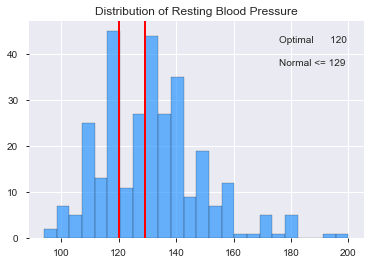

In [37]:
norm_bot = 120
norm_top = 129

result = plt.hist(df[['trestbps']].values, bins=24, color='dodgerblue', edgecolor='k', alpha=0.65)
plt.axvline(norm_bot, color='r', linewidth=2)
plt.axvline(norm_top, color='r', linewidth=2)

_, max_ = plt.ylim()

plt.text(160 + 160/10, 
         max_ - max_/10, 
         'Optimal      {:}'.format(norm_bot))

plt.text(160 + 160/10, 
         max_ - max_/10 - 5, 
         'Normal <= {:}'.format(norm_top))

plt.title('Distribution of Resting Blood Pressure')

Text(0.5, 1.0, 'Distribution of Cholesterine Concentration mg/dl')

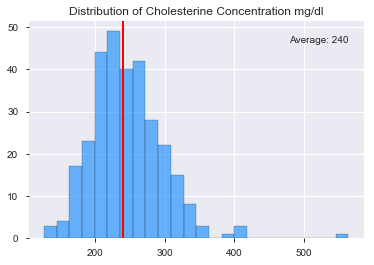

In [38]:
avg = 240

result = plt.hist(df[['chol']].values, bins=24, color='dodgerblue', edgecolor='k', alpha=0.65)
plt.axvline(avg, color='r', linewidth=2)

_, max_ = plt.ylim()

plt.text(435 + 435/10, 
         max_ - max_/10, 
         'Average: {:}'.format(avg))

plt.title('Distribution of Cholesterine Concentration mg/dl')

In [39]:
#pandas_profiling.ProfileReport(df)

### Feature Selection

In [40]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


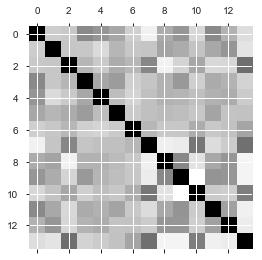

In [41]:
plt.matshow(df.corr())

In [42]:
from sklearn.feature_selection import f_classif, SelectKBest

In [43]:
def select_kbest_clf(data_frame, target, k=5):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

In [44]:
select_kbest_clf(df, 'target')

,F Score,P Value,Support,Attribute
0,16.116700,7.524801e-05,False,age
1,25.792191,6.678692e-07,False,sex
2,69.772271,2.469712e-15,True,cp
3,6.458169,1.154606e-02,False,trestbps
4,2.202983,1.387903e-01,False,chol
5,0.236942,6.267775e-01,False,fbs
6,5.777209,1.683990e-02,False,restecg
7,65.120104,1.697338e-14,True,thalach
8,70.952438,1.520814e-15,True,exang
9,68.551439,4.085346e-15,True,oldpeak


In [45]:
scores = select_kbest_clf(df, 'target')

In [46]:
features = scores['Attribute'].where(scores['Support']).dropna()
features

2          cp
7     thalach
8       exang
9     oldpeak
11         ca
Name: Attribute, dtype: object

In [47]:
type(features)

pandas.core.series.Series

In [48]:
df_selected = df[['cp', 'thalach', 'exang', 'oldpeak', 'ca', 'target']]

In [49]:
df_selected.head()

,cp,thalach,exang,oldpeak,ca,target
0,3,150,0,2.3,0,1
1,2,187,0,3.5,0,1
2,1,172,0,1.4,0,1
3,1,178,0,0.8,0,1
4,0,163,1,0.6,0,1


## Modeling

In [50]:
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import f_classif, SelectKBest

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

### Data Preprocessing

In [51]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:,:-1],df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [91]:
# transformation
# remove outlier

### Modeling - KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_pipe.set_params(
    kbest__k=5,
    knn__n_neighbors=11, knn__n_jobs=-1
)

knn_pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform'))])

In [53]:
knn_pipe.score(X_test, y_test)

0.8524590163934426

In [54]:
knn_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'kbest', 'scaler', 'knn', 'kbest__k', 'kbest__score_func', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])

In [61]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

knn_params = {
        'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': [20, 30, 40],
    
        'kbest__k': [3, 5, 7, 9, 11, 13, 'all']
        }

folds = 5

params_comb_all = int(7 * 3 * 3 * 7)
param_comb = int(params_comb_all / 2)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = random_state)

print('GridSearchCV parameter combinations: ' + str(params_comb_all) + '\n' + 'RandomizedSearchCV parameter combinations: ' + str(param_comb))

GridSearchCV parameter combinations: 441
RandomizedSearchCV parameter combinations: 220


In [62]:
rnd_search_knn = RandomizedSearchCV(knn_pipe, param_distributions=knn_params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=random_state )
rnd_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:  1.1min finished
C:\Users\leano\Anaconda3\envs\Testenv\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000294259875C8>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform'))]),
          fit_params=None, iid='warn', n_iter=220, n_jobs=-1,
          param_distributions={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'], 'knn__leaf_size': [20, 30, 40], 'kbest__k': [3, 5, 7, 9, 11, 13, 'all']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [63]:
rnd_search_knn.best_estimator_

Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k='all', score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='brute', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform'))])

In [64]:
rnd_search_knn.best_estimator_.score(X_test,y_test)

0.8852459016393442

In [65]:
grid_search_knn = GridSearchCV(knn_pipe, param_grid=knn_params, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3)
grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 441 candidates, totalling 2205 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2205 out of 2205 | elapsed:  2.1min finished
C:\Users\leano\Anaconda3\envs\Testenv\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000002942480FD00>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'], 'knn__leaf_size': [20, 30, 40], 'kbest__k': [3, 5, 7, 9, 11, 13, 'all']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [68]:
grid_search_knn.best_estimator_

Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=13, score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform'))])

In [69]:
grid_search_knn.best_estimator_.score(X_test,y_test)

0.8852459016393442

In [90]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = grid_search_knn.best_estimator_.predict(X_test)

print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred))

Precision:  0.8787878787878788
Recall:  0.90625
Confusion Matrix:  
 [[25  4]
 [ 3 29]]


### Modeling - xgboost

In [70]:
from xgboost import XGBClassifier

xgc_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('xgc', XGBClassifier())
])

xgc_pipe.set_params(
    kbest__k=5,
    xgc__learning_rate=.02, xgc__max_depth=5, xgc__n_estimators=500
)

xgc_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgc', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_de...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [71]:
xgc_pipe.score(X_test, y_test)

0.819672131147541

In [72]:
xgc_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'kbest', 'scaler', 'xgc', 'kbest__k', 'kbest__score_func', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'xgc__base_score', 'xgc__booster', 'xgc__colsample_bylevel', 'xgc__colsample_bytree', 'xgc__gamma', 'xgc__learning_rate', 'xgc__max_delta_step', 'xgc__max_depth', 'xgc__min_child_weight', 'xgc__missing', 'xgc__n_estimators', 'xgc__n_jobs', 'xgc__nthread', 'xgc__objective', 'xgc__random_state', 'xgc__reg_alpha', 'xgc__reg_lambda', 'xgc__scale_pos_weight', 'xgc__seed', 'xgc__silent', 'xgc__subsample'])

In [75]:
xgc_params = {
        'xgc__min_child_weight': [1, 5, 10],
        'xgc__gamma': [0.5, 1, 1.5, 2, 5],
        'xgc__subsample': [0.6, 0.8, 1.0],
        'xgc__colsample_bytree': [0.6, 0.8, 1.0],
        'xgc__max_depth': [3, 4, 5],
    
        'kbest__k': [3, 5, 7, 9, 11, 13, 'all']
        }

params_comb_all = int(3 * 5 * 3 * 3 * 3 * 7)
param_comb = int(params_comb_all / 5)

folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = random_state)

print('GridSearchCV parameter combinations: ' + str(params_comb_all) + '\n' + 'RandomizedSearchCV parameter combinations: ' + str(param_comb))

GridSearchCV parameter combinations: 2835
RandomizedSearchCV parameter combinations: 567


In [76]:
rnd_search_xgc = RandomizedSearchCV(xgc_pipe, param_distributions=xgc_params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=random_state )
rnd_search_xgc.fit(X_train, y_train)

Fitting 5 folds for each of 567 candidates, totalling 2835 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2835 out of 2835 | elapsed:  3.9min finished
C:\Users\leano\Anaconda3\envs\Testenv\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequ

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000029425779048>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgc', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_de...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=567, n_jobs=-1,
          param_distributions={'xgc__min_child_weight': [1, 5, 10], 'xgc__gamma': [0.5, 1, 1.5, 2, 5], 'xgc__subsample': [0.6, 0.8, 1.0], 'xgc__colsample_bytree': [0.6, 0.8, 1.0], 'xgc__max_depth': [3, 4, 5], 'kbest__k': [3, 5, 7, 9, 11, 13, 'all']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='

In [77]:
rnd_search_xgc.best_estimator_

Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=9, score_func=<function f_classif at 0x0000029424A1C2F0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgc', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=2, learning_rate=0.02, max_...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6))])

In [78]:
rnd_search_xgc.best_estimator_.score(X_test,y_test)

0.8688524590163934

In [81]:
y_pred = rnd_search_xgc.best_estimator_.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[24,  5],
       [ 3, 29]], dtype=int64)

In [ ]:
grid_search_xgc = GridSearchCV(xgc_pipe, param_grid=xgc_params, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3 )
grid_search_xgc.fit(X_train, y_train)

In [ ]:
grid_search_xgc.best_estimator_

In [ ]:
grid_search_xgcbest_estimator_.score(X_test,y_test)